<a href="https://colab.research.google.com/github/y2236li/Algorithm-Practice/blob/master/1D_Climber_Accuracy_Only.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
cd drive/My\ Drive/kiwi_research/kiwi_project

/content/drive/My Drive/kiwi_research/kiwi_project


In [0]:
from sklearn.preprocessing import MinMaxScaler
import os
import tensorflow as tf
import collections
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from sklearn.cross_decomposition import PLSRegression
from keras.layers import Dense, Activation
from keras.models import Sequential, load_model
from keras.optimizers import Adam, SGD

In [0]:
def calAccuracy(x):
  """
  Calculate the accuracy
  return: accuracy
  """
  pls2 = PLSRegression(n_components=x)
  pls2.fit(X_train, Y_train)
  Y_pred = pls2.predict(X_test)
  y = r2_score(Y_pred, Y_test)

  return y


def calReward(x):
  return accuracy_lookuptb[x]

def detect(detect_range, x, accuracy_lookuptb = None):
  """
  return the accuracy of detecting area around the x
  
  """
  x_detect_range = np.array(detect_range) + x
  if not accuracy_lookuptb:
    return [calAccuracy(pos) if pos in x_range else 0 for pos in x_detect_range]
  assert x in accuracy_lookuptb
  return [accuracy_lookuptb[pos] if pos in x_range else 0 for pos in x_detect_range]


def step(cur_state, action, cur_x, accuracy_lookuptb = None):
  next_x = max(min(max(x_range), cur_x + action), 1)
  if not accuracy_lookuptb:
    next_state = detect(detect_range, next_x)
  else:
    next_state = detect(detect_range, next_x, accuracy_lookuptb)
  reward = calReward(next_x)
  return (next_state, reward)

def writeMem(cur_state, next_state, action, reward):
  index = mem_ctr % mem_size
  state_mem[index] = cur_state
  next_state_mem[index] = next_state
  tmp_onehot = np.zeros(len(step_options), dtype=np.int64)
  tmp_onehot[step_options.index(action)] = 1
  onehot_action_mem[index] = tmp_onehot
  reward_nor_mem[index] = reward



def calAccuracyTest(x):
  """
  Calculate the accuracy
  return: accuracy
  """
  pls2 = PLSRegression(n_components=x)
  pls2.fit(X_train_test, Y_train_test)
  Y_pred = pls2.predict(X_test_test)
  y = r2_score(Y_pred, Y_test_test)
  return y

def calRewardTest(x):
  return scaler_state.transform(accuracy_lookuptb_test[x])


def detectTest(detect_range, x):
  """
  return the accuracy of detecting area around the x
  """
  x_detect_range = np.array(detect_range, dtype=np.int64) + int(x)
  return [calRewardTest(pos) if pos in x_range else 0 for pos in x_detect_range]



def stepTest(cur_state, action, cur_x):
  next_x = int(max(min(max(x_range), cur_x + action), 1))
  next_state = detectTest(detect_range, next_x)
  reward = calRewardTest(next_x)
  return (next_state, reward)

def writeMem(cur_state, next_state, action, reward):
  index = mem_ctr % mem_size
  state_mem[index] = cur_state
  next_state_mem[index] = next_state
  tmp_onehot = np.zeros(len(step_options), dtype=np.int64)
  tmp_onehot[step_options.index(action)] = 1
  onehot_action_mem[index] = tmp_onehot
  reward_nor_mem[index] = reward

## Global Variables

In [0]:
f_xy = open("pickles/XYtraintest.pk1", "rb")
X_train, X_test, Y_train, Y_test = pickle.load(f_xy)
f_xy.close()

x_range = range(1, 200)

idle_range = 0.001 # if the change of recent steps (idle steps) did not have a change of this range. Game will be over
idle_steps = 5

detect_range = [-3, -1, 0, 1, 3] # also input dim
step_options = [-3, -1, 0, 1, 3] # also action space

lr = 0.01 # also alpha
one_game_steps = 300


gamma = 0.8


#memory variables
mem_ctr = 0
state_mem = {}
onehot_action_mem = {}
reward_nor_mem = {}
next_state_mem = {}
terminal_mem = {}

## Find a accuracy map with relatively wide range of accuracy

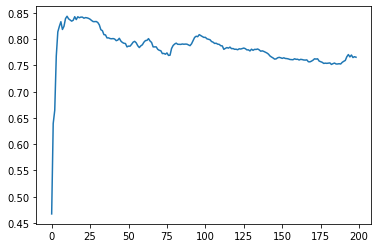

10


In [10]:
X = np.concatenate((X_train, X_test))
Y = np.concatenate((Y_train, Y_test))
train_indices = np.random.choice(X.shape[0], 300, replace=False)
test_indices = np.array([x for x in range(X.shape[0]) if x not in train_indices])
X_train = X[train_indices]
X_test = X[test_indices]
Y_train = Y[train_indices]
Y_test = Y[test_indices]
accuracy_list = []
for x in x_range:
  accuracy_list.append(calAccuracy(x))
plt.plot(accuracy_list)
plt.show()
print(np.argmax(accuracy_list))

## Game Initialization

In [0]:
mem_size = one_game_steps * 4
batch_size = int(one_game_steps /64) * 64
assert batch_size <= mem_size
random_walk_period = batch_size

accuracy_lookuptb = dict(zip(*(x_range, accuracy_list)))

random_walk_period = batch_size
scaler_state = MinMaxScaler()
scaler_state.fit([detect(detect_range, x, accuracy_lookuptb) for x in x_range if np.prod(detect(detect_range, x, accuracy_lookuptb)) > 0])

scaler_reward = MinMaxScaler()
scaler_reward.fit([[x] for x in accuracy_list])

init_x = 190
detection = detect(detect_range, init_x, accuracy_lookuptb)
cur_nor_state = scaler_state.transform([detection])[0]
cur_state = scaler_state.inverse_transform([cur_nor_state])[0]

init_state = cur_state
init_nor_state = cur_nor_state

## Make a NN

In [0]:
def makeModel():
  fc1_dims = 200
  fc2_dims = 200
  model = Sequential([
      Dense(fc1_dims, input_shape=(np.array(cur_state).shape[0],)),
      Activation('relu'),
      Dense(fc2_dims),
      Activation('relu'),
      Dense(len(step_options))
  ])


  model.compile(optimizer=SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True), loss='mse')

  return model

q_model = makeModel()

## Main

In [145]:
mem_ctr = 0
state_mem = {}
onehot_action_mem = {}
reward_nor_mem = {}
next_state_mem = {}
terminal_mem = {}

reward_nor_his = []

n_games = 10
gamma = 0.5

epsilon = 0.1
epsilon_dec = 0.8

cur_x = init_x

rule_idle = True

idle_range = 0.0002
idle_steps = 5
reward_nor_buffer = []

last_action = 0
momentum_counter = 0
count_momentum = True


for _ in tqdm(range(n_games)):
  cur_x = np.random.choice(x_range)
  for step_ctr in range(one_game_steps):
    
  # predict action
    
    if count_momentum:
      last_action = action

    if mem_ctr < random_walk_period or np.random.uniform() <= epsilon:
      action = np.random.choice(step_options)
    else:
      # once random walk were done, the state in memory will be normalized

      indices = np.random.choice(len(state_mem), batch_size, replace=False)

      batch_states = np.array(list(state_mem.values()))[indices]
      batch_next_states = np.array(list(next_state_mem.values()))[indices]
      batch_actions = np.array(list(onehot_action_mem.values()))[indices]
      batch_rewards = np.array(list(reward_nor_mem.values()))[indices]

      q_matrix = q_model.predict(batch_states)
      q_next = q_model.predict(batch_next_states)

      actions_indices = np.dot(batch_actions, np.arange(len(step_options), dtype=np.int64))
      batch_indices = np.arange(batch_size, dtype=np.int64)

      q_matrix[batch_indices, actions_indices] = batch_rewards + gamma*np.max(q_next, axis=1)


      q_model.fit(batch_states, q_matrix, verbose=0, epochs = 1)

      action = step_options[np.argmax(q_model.predict(cur_nor_state.reshape(1, len(cur_state))))]
    
    if action == 0:
      action = np.random.choice([1, -1])

    
    if count_momentum and last_action * action >0:
      momentum_counter += 1
    next_state, reward = step(cur_state, action, cur_x, accuracy_lookuptb)
    reward_nor = scaler_reward.transform([[reward]])[0][0]

    if rule_idle:
      try:
        reward_nor_buffer[mem_ctr%idle_steps] = reward_nor
        if mem_ctr >= random_walk_period and max(reward_nor_buffer) - min(reward_nor_buffer) < idle_range:
          break
      except:
        reward_nor_buffer.append(reward_nor)
    

    next_nor_state = scaler_state.transform([next_state])[0]
    next_x = max(min(cur_x + action, 200), 1)
    
    writeMem(cur_nor_state, next_nor_state, action, reward_nor)

    # print("cur_state = %s, cur_x = %s, action = %s, reward = %s"%(str(cur_state), str(cur_x), str(action), str(reward)))
    # print(reward_nor_buffer, max(reward_nor_buffer)- min(reward_nor_buffer))
    reward_nor_his.append(reward_nor)

    cur_state = next_state
    cur_nor_state = next_nor_state
    cur_x = next_x

    mem_ctr += 1

if count_momentum:
  print("Momentum = ", momentum_counter/mem_ctr)






  0%|          | 0/10 [00:00<?, ?it/s]




 10%|█         | 1/10 [00:02<00:20,  2.24s/it]




 20%|██        | 2/10 [00:08<00:26,  3.33s/it]




 30%|███       | 3/10 [00:13<00:28,  4.09s/it]




 40%|████      | 4/10 [00:14<00:18,  3.13s/it]




 50%|█████     | 5/10 [00:16<00:13,  2.79s/it]




 60%|██████    | 6/10 [00:18<00:09,  2.38s/it]




 70%|███████   | 7/10 [00:24<00:10,  3.45s/it]




 80%|████████  | 8/10 [00:29<00:08,  4.01s/it]




 90%|█████████ | 9/10 [00:30<00:03,  3.19s/it]




100%|██████████| 10/10 [00:32<00:00,  2.61s/it]






Momentum =  0.5331846068042387


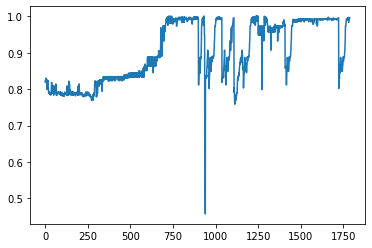

In [146]:
plt.plot([x for x in reward_nor_his if x > 0])